In [1]:
### Human Motion Prediction Example ###
# state-of-the-art approaches use recusive encoders and decoders.
# this is meant to be a gentle introduction, not the "best" approach

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [2]:
### Autoencoder Model ###

class Autoencoder(nn.Module):
    def __init__(self, history_dim, prediction_dim, latent_dim, hidden_dim):
        super(Autoencoder, self).__init__()

        # encoder architecture
        self.linear1 = nn.Linear(history_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, latent_dim)

        # decoder architecture
        self.linear4 = nn.Linear(latent_dim, hidden_dim)
        self.linear5 = nn.Linear(hidden_dim, hidden_dim)
        self.linear6 = nn.Linear(hidden_dim, prediction_dim)

        # loss function: ||x - y||^2
        self.loss_fcn = nn.MSELoss()

    # encoder takes in history and outputs latent z
    def encoder(self, history):
        h1 = torch.tanh(self.linear1(history))
        h2 = torch.tanh(self.linear2(h1))
        return self.linear3(h2)

    # decoder takes in latent z and outputs prediction
    def decoder(self, z):
        h4 = torch.tanh(self.linear4(z))
        h5 = torch.tanh(self.linear5(h4))
        return self.linear6(h5)

    # compare prediction to actual future
    def forward(self, history, future):
        prediction = self.decoder(self.encoder(history))
        return self.loss_fcn(future, prediction)

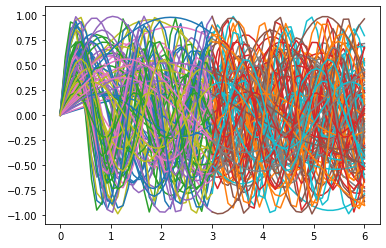

In [3]:
### Generate the Training Data ###

# make N sine waves
# each sine wave is split in half:
# the first half is the history, and the second half is the future
# the amplitute and frequency are randomized

N = 100
start_t = 0.0
curr_t = 3.0
end_t = 6.0
history_timesteps = np.linspace(start_t, curr_t, 30)
future_timesteps = np.linspace(curr_t, end_t, 30)
dataset = []
for _ in range(N):
  amp = np.random.uniform(0.2, 1.0)
  freq = 2*np.pi*np.random.uniform(0.1, 1.0)
  history = amp*np.sin(freq*history_timesteps)
  future = amp*np.sin(freq*future_timesteps)
  dataset.append((torch.FloatTensor(history), torch.FloatTensor(future)))
  plt.plot(history_timesteps, history)
  plt.plot(future_timesteps, future)
plt.show()

In [ ]:
### Train the BC Model ###

# arguments: history_dim, prediction_dim, latent_dim, hidden_dim
model = Autoencoder(30, 30, 10, 32)

# hyperparameters for training
EPOCH = 2001
BATCH_SIZE_TRAIN = 100
LR = 0.001

# training loop
optimizer = optim.Adam(model.parameters(), lr=LR)
for epoch in range(EPOCH):
  optimizer.zero_grad()
  loss = 0
  batch = np.random.choice(len(dataset), size=BATCH_SIZE_TRAIN, replace=False)
  for index in batch:
    item = dataset[index]
    loss += model(item[0], item[1])
  loss.backward()
  optimizer.step()
  if epoch % 100 == 0:
    print(epoch, loss.item())

0 21.248249053955078
100 10.632434844970703
200 2.2612874507904053
300 0.6548289060592651
400 0.28719472885131836
500 0.15014848113059998
600 0.09450452029705048
700 0.06726648658514023
800 0.05145340412855148
900 0.04233790561556816
1000 0.03849542513489723
1100 0.03055742010474205
1200 0.02626430243253708
1300 0.02339114621281624
1400 0.02103869989514351
1500 0.020270006731152534


In [ ]:
### Predict the Motion ###

# given this history
amp = np.random.uniform(0.2, 1.0)
freq = 2*np.pi*np.random.uniform(0.1, 1.0)
history = amp*np.sin(freq*history_timesteps)

# predict the future trajectory
z = model.encoder(torch.FloatTensor(history))
prediction = model.decoder(z).detach().numpy()

# plot the history, prediction, and actual trajectory
plt.plot(history_timesteps, history)
plt.plot(future_timesteps, amp*np.sin(freq*future_timesteps), 'x--')
plt.plot(future_timesteps, prediction, 'o-')
plt.show()